In [1]:
"""
Novel View Generation for ScanNet Scenes — Coverage-Gap Approach
================================================================

Given a ScanNet scene (set of RGB frames + 4×4 camera-to-world extrinsics),
this notebook:

1. Parses every pose file to extract camera positions & viewing directions.
2. Builds an azimuth histogram of viewing directions and finds the angular
   sector(s) with the **least camera coverage**.
3. Picks the existing frame whose viewing direction is closest to the gap.
4. Computes the angular delta (horizontal rotation + vertical tilt) between
   that frame and the gap centre.
5. Feeds the frame + delta into the **Qwen Image-Edit Camera-Control** model
   (with the Rapid distilled transformer + camera LoRA) to synthesise a
   novel view filling the coverage gap.
"""

# ── Cache configuration ─────────────────────────────────────────────────
# MUST run before any HF / torch imports so the libraries pick up the
# env vars at module-init time.  This keeps everything on the large
# /ocean filesystem and avoids filling up the small home directory.
import os
from pathlib import Path

HF_ROOT = "/ocean/projects/cis250206p/aanugu"

_cache_vars = {
    # Hugging Face core
    "HF_HOME":            f"{HF_ROOT}/hf-cache",
    "HF_HUB_CACHE":       f"{HF_ROOT}/hf-cache/hub",
    "TRANSFORMERS_CACHE":  f"{HF_ROOT}/tf-cache",
    "HF_DATASETS_CACHE":   f"{HF_ROOT}/ds-cache",
    "DIFFUSERS_CACHE":     f"{HF_ROOT}/diff-cache",
    # General XDG / pip / torch caches — the usual ~/.cache culprits
    "XDG_CACHE_HOME":      f"{HF_ROOT}/.cache",
    "PIP_CACHE_DIR":       f"{HF_ROOT}/.cache/pip",
    "TORCH_HOME":          f"{HF_ROOT}/.cache/torch",
    # HPC stability
    "HF_HUB_DISABLE_XET":              "1",
    "HF_HUB_ENABLE_HF_TRANSFER":       "1",
    "HF_HUB_DISABLE_SYMLINKS_WARNING":  "1",
}

for key, val in _cache_vars.items():
    os.environ[key] = val
    # Create directory for any path-like value (skip flags like "1")
    if "/" in val:
        Path(val).mkdir(parents=True, exist_ok=True)

print("Cache roots (all on /ocean, nothing in ~/):")
for k in ["HF_HOME", "TORCH_HOME", "XDG_CACHE_HOME", "PIP_CACHE_DIR"]:
    print(f"  {k} = {os.environ[k]}")

# ── Now safe to import everything else ──────────────────────────────────
import json, glob, math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

Cache roots (all on /ocean, nothing in ~/):
  HF_HOME = /ocean/projects/cis250206p/aanugu/hf-cache
  TORCH_HOME = /ocean/projects/cis250206p/aanugu/.cache/torch
  XDG_CACHE_HOME = /ocean/projects/cis250206p/aanugu/.cache
  PIP_CACHE_DIR = /ocean/projects/cis250206p/aanugu/.cache/pip


In [29]:
# ── Config ──────────────────────────────────────────────────────────────
DATA_ROOT   = Path("../data/qa/scannetv2/frames_square")
SCENE_ID    = "scene0100_00"          # <-- change to any scene you want

SCENE_DIR   = DATA_ROOT / SCENE_ID
COLOR_DIR   = SCENE_DIR / "color"
POSE_DIR    = SCENE_DIR / "pose"

# Azimuth histogram resolution (degrees per bin)
BIN_DEG = 20

print(f"Scene : {SCENE_ID}")
print(f"Images: {len(list(COLOR_DIR.glob('*.jpg')))} frames")
print(f"Poses : {len(list(POSE_DIR.glob('*.txt')))} files")

Scene : scene0100_00
Images: 51 frames
Poses : 51 files


In [30]:
# ── Step 1: Load all camera extrinsics ──────────────────────────────────
#
# Each pose/<frame_id>.txt is a 4×4 camera-to-world matrix:
#   [ R  t ]      R = 3×3 rotation,  t = 3×1 translation (camera position)
#   [ 0  1 ]
#
# The camera looks along its local −Z axis.  In world coordinates the
# viewing direction is:   d = R @ [0, 0, -1]^T  (third column, negated).

def load_poses(pose_dir: Path):
    """Return {frame_id: 4×4 ndarray} for every valid pose file."""
    poses = {}
    for f in sorted(pose_dir.glob("*.txt")):
        frame_id = int(f.stem)
        mat = np.loadtxt(f)
        # ScanNet sometimes has inf/nan in broken poses — skip those
        if mat.shape == (4, 4) and np.isfinite(mat).all():
            poses[frame_id] = mat
    return poses

poses = load_poses(POSE_DIR)
print(f"Loaded {len(poses)} valid poses (out of {len(list(POSE_DIR.glob('*.txt')))} files)")

Loaded 51 valid poses (out of 51 files)


In [31]:
# ── Step 2: Extract viewing directions ──────────────────────────────────
#
# For each camera we compute:
#   • azimuth  (yaw on the horizontal XY-plane, in degrees, 0–360)
#   • elevation (pitch above/below horizontal, in degrees)
#
# Convention:  ScanNet pose files are camera-to-world matrices using the
# OpenCV camera model (X-right, Y-down, Z-forward).  The camera looks
# along its local +Z axis, so the viewing direction in world coords is:
#   d = R @ [0, 0, 1]  =  R[:, 2]   (third column of R)

frame_ids = []
positions = []       # (N, 3)  camera centres in world coords
azimuths  = []       # degrees, [0, 360)
elevations = []      # degrees, (−90, 90)

for fid in sorted(poses.keys()):
    T = poses[fid]
    R = T[:3, :3]
    t = T[:3,  3]

    # viewing direction in world frame  (+Z = forward in OpenCV convention)
    d = R @ np.array([0.0, 0.0, 1.0])
    d = d / (np.linalg.norm(d) + 1e-12)

    az  = math.degrees(math.atan2(d[1], d[0])) % 360   # 0-360
    el  = math.degrees(math.asin(np.clip(d[2], -1, 1))) # -90..90

    frame_ids.append(fid)
    positions.append(t)
    azimuths.append(az)
    elevations.append(el)

azimuths   = np.array(azimuths)
elevations = np.array(elevations)
positions  = np.array(positions)
frame_ids  = np.array(frame_ids)

print(f"Azimuth  range: [{azimuths.min():.1f}°, {azimuths.max():.1f}°]")
print(f"Elevation range: [{elevations.min():.1f}°, {elevations.max():.1f}°]")

Azimuth  range: [12.4°, 358.9°]
Elevation range: [-43.9°, -12.2°]


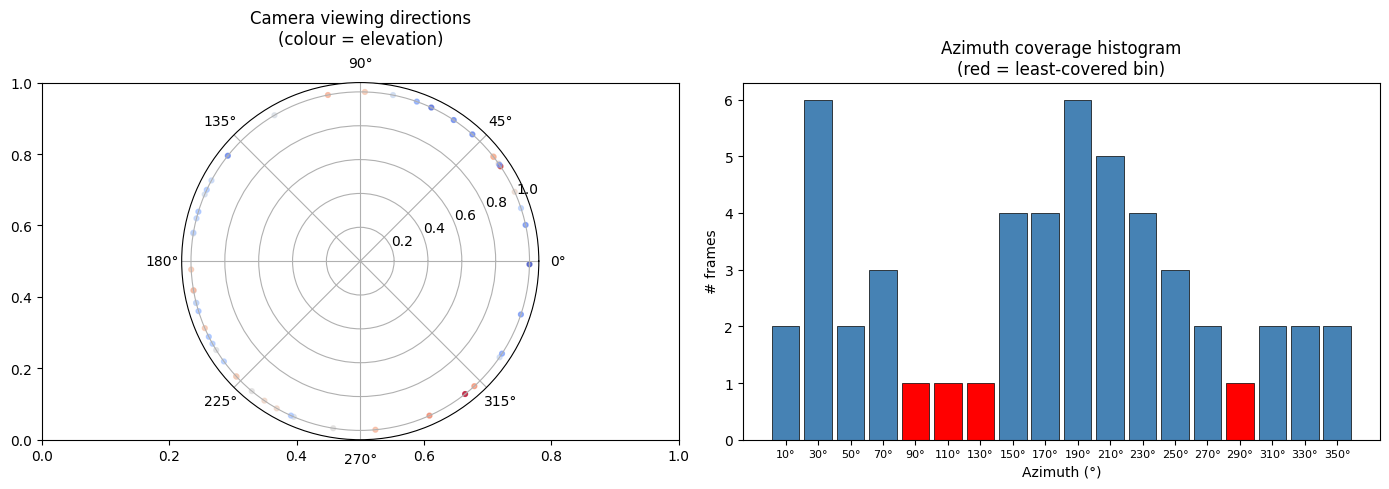


Least-covered azimuth bin(s): [ 90. 110. 130. 290.] (only 1 frames each)
We will target the first gap at azimuth ≈ 90°


In [33]:
# View one sample
# ── Step 3: Build azimuth histogram & find coverage gaps ────────────────

n_bins = int(360 / BIN_DEG)
bin_edges = np.linspace(0, 360, n_bins + 1)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

counts, _ = np.histogram(azimuths, bins=bin_edges)

# ── Visualise ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: polar scatter of camera viewing directions
ax_polar = fig.add_subplot(121, polar=True)
ax_polar.scatter(np.radians(azimuths), np.ones_like(azimuths), c=elevations,
                 cmap="coolwarm", s=12, alpha=0.7)
ax_polar.set_title("Camera viewing directions\n(colour = elevation)", va="bottom")

# Right: azimuth histogram
ax_hist = axes[1]
colours = ["red" if c == counts.min() else "steelblue" for c in counts]
ax_hist.bar(bin_centres, counts, width=BIN_DEG * 0.85, color=colours, edgecolor="k", linewidth=0.5)
ax_hist.set_xlabel("Azimuth (°)")
ax_hist.set_ylabel("# frames")
ax_hist.set_title("Azimuth coverage histogram\n(red = least-covered bin)")
ax_hist.set_xticks(bin_centres)
ax_hist.set_xticklabels([f"{int(b)}°" for b in bin_centres], fontsize=8)

plt.tight_layout()
plt.show()

# Identify the gap bin(s) — the bin with the minimum count
gap_mask     = counts == counts.min()
gap_centres  = bin_centres[gap_mask]
gap_count    = counts.min()

print(f"\nLeast-covered azimuth bin(s): {gap_centres} (only {gap_count} frames each)")
print(f"We will target the first gap at azimuth ≈ {gap_centres[0]:.0f}°")

Target gap azimuth : 90.0°
Best source frame  : frame 820  (azimuth 88.4°, elevation -24.0°)
Required rotation  : +1.6°  (left)
Absolute delta     : 1.6°


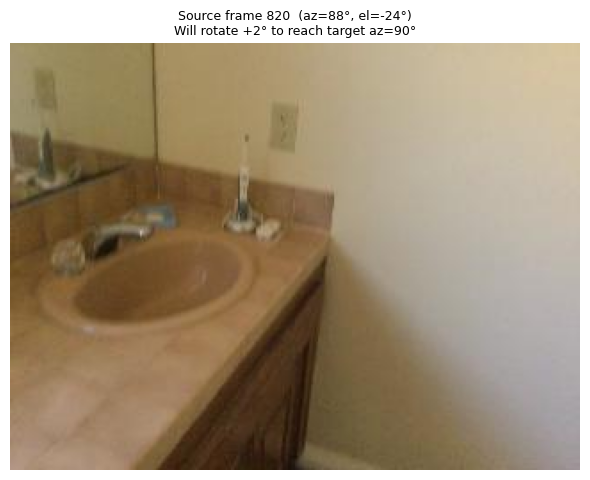

In [34]:
# ── Step 4: Pick the best source frame for generation ───────────────────
#
# Strategy: find the existing frame whose azimuth is **closest** to the
# gap centre.  The Qwen camera-control LoRA can reliably rotate up to ±90°,
# so we want the smallest angular delta we can get.

target_az = gap_centres[0]  # azimuth we want to see

def angular_distance(a, b):
    """Signed shortest angular distance from a to b (degrees), in (−180, 180]."""
    d = (b - a) % 360
    if d > 180:
        d -= 360
    return d

deltas = np.array([angular_distance(az, target_az) for az in azimuths])
abs_deltas = np.abs(deltas)

best_idx    = int(np.argmin(abs_deltas))
source_fid  = frame_ids[best_idx]
source_az   = azimuths[best_idx]
source_el   = elevations[best_idx]
rotate_deg  = float(deltas[best_idx])  # positive = left in Qwen convention

print(f"Target gap azimuth : {target_az:.1f}°")
print(f"Best source frame  : frame {source_fid}  (azimuth {source_az:.1f}°, elevation {source_el:.1f}°)")
print(f"Required rotation  : {rotate_deg:+.1f}°  ({'left' if rotate_deg > 0 else 'right'})")
print(f"Absolute delta     : {abs_deltas[best_idx]:.1f}°")

if abs_deltas[best_idx] > 90:
    print("⚠  Warning: delta > 90° — generation quality may degrade. "
          "Consider using an intermediate step.")

# Load & show the source image
source_path = COLOR_DIR / f"{source_fid}.jpg"
source_image = Image.open(source_path).convert("RGB")

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.imshow(source_image)
ax.set_title(f"Source frame {source_fid}  (az={source_az:.0f}°, el={source_el:.0f}°)\n"
             f"Will rotate {rotate_deg:+.0f}° to reach target az={target_az:.0f}°", fontsize=9)
ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# ── Step 5: Load the Qwen Camera-Control pipeline ──────────────────────
#
# This mirrors the setup from qwen_camera_control.ipynb:
#   1. Load the distilled Rapid transformer (4-step inference)
#   2. Load the base Qwen-Image-Edit pipeline
#   3. Load + fuse the camera-angle LoRA at scale 1.25
#
# NOTE: Cache env vars were already set in cell 0 (before any imports)
#       so all downloads go to /ocean, not ~/.cache.
'''

import torch
from diffusers import QwenImageEditPlusPipeline, QwenImageTransformer2DModel

dtype = torch.bfloat16

# 1) Distilled transformer
print("Loading distilled transformer …")
transformer = QwenImageTransformer2DModel.from_pretrained(
    "linoyts/Qwen-Image-Edit-Rapid-AIO",
    subfolder="transformer",
    torch_dtype=dtype,
    low_cpu_mem_usage=True,
)
print("✓ Transformer loaded")

# 2) Full pipeline with the rapid transformer swapped in
print("Loading pipeline …")
pipe = QwenImageEditPlusPipeline.from_pretrained(
    "Qwen/Qwen-Image-Edit-2509",
    transformer=transformer,
    torch_dtype=dtype,
    low_cpu_mem_usage=True,
).to("cuda")
print("✓ Pipeline loaded")

# 3) Camera-angle LoRA
print("Loading camera-angle LoRA …")
pipe.load_lora_weights(
    "dx8152/Qwen-Edit-2509-Multiple-angles",
    weight_name="\u955c\u5934\u8f6c\u6362.safetensors",   # 镜头转换.safetensors
    adapter_name="angles",
)
pipe.set_adapters(["angles"], adapter_weights=[1.0])
pipe.fuse_lora(adapter_names=["angles"], lora_scale=1.25)
pipe.unload_lora_weights()
print("✓ Camera LoRA fused — pipeline ready!")
'''

/jet/home/aanugu/.conda/envs/cdviews/lib/python3.10/site-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/jet/home/aanugu/.conda/envs/cdviews/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading distilled transformer …


/jet/home/aanugu/.conda/envs/cdviews/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [02:28<00:00, 37.05s/it]


✓ Transformer loaded
Loading pipeline …


Loading pipeline components...: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


✓ Pipeline loaded
Loading camera-angle LoRA …
✓ Camera LoRA fused — pipeline ready!


In [35]:
# ── Step 6: Prompt builder & generation function ───────────────────────
#
# Reused from qwen_camera_control.ipynb with one small addition:
# we clamp rotation to ±90° (the LoRA's reliable range) and warn if we
# had to clamp.

import random

def build_camera_prompt(
    rotate_deg: float = 0.0,
    move_forward: float = 0.0,
    vertical_tilt: float = 0.0,
    wideangle: bool = False,
) -> str:
    """Build a bilingual (Chinese + English) camera movement prompt."""
    parts = []
    if rotate_deg != 0:
        direction = "left" if rotate_deg > 0 else "right"
        cn_dir    = "左"  if rotate_deg > 0 else "右"
        parts.append(
            f"将镜头向{cn_dir}旋转{abs(rotate_deg):.0f}度 "
            f"Rotate the camera {abs(rotate_deg):.0f} degrees to the {direction}."
        )
    if move_forward > 5:
        parts.append("将镜头转为特写镜头 Turn the camera to a close-up.")
    elif move_forward >= 1:
        parts.append("将镜头向前移动 Move the camera forward.")
    if vertical_tilt <= -1:
        parts.append("将相机转向鸟瞰视角 Turn the camera to a bird's-eye view.")
    elif vertical_tilt >= 1:
        parts.append("将相机切换到仰视视角 Turn the camera to a worm's-eye view.")
    if wideangle:
        parts.append("将镜头转为广角镜头 Turn the camera to a wide-angle lens.")
    return " ".join(parts).strip() if parts else "no camera movement"


def generate_novel_view(
    image: Image.Image,
    rotate_deg: float,
    vertical_tilt: float = 0.0,
    seed: int = 42,
    num_inference_steps: int = 4,
) -> tuple:
    """
    Generate a novel view by rotating the camera.
    
    Args:
        image:        Source PIL image.
        rotate_deg:   Horizontal rotation (positive = left, negative = right).
                      Clamped to [-90, 90].
        vertical_tilt: -1 = bird's-eye, 0 = level, 1 = worm's-eye.
        seed:         Random seed for reproducibility.
    
    Returns:
        (generated_image, actual_rotation_used, prompt_string)
    """
    # Clamp to the LoRA's reliable range
    clamped = max(-90.0, min(90.0, rotate_deg))
    if clamped != rotate_deg:
        print(f"⚠  Rotation clamped from {rotate_deg:.1f}° to {clamped:.1f}°")
    
    prompt = build_camera_prompt(rotate_deg=clamped, vertical_tilt=vertical_tilt)
    print(f"Prompt: {prompt}")
    
    if prompt == "no camera movement":
        return image, clamped, prompt
    
    # Auto-compute output dims preserving aspect ratio, max side = 1024
    w, h = image.size
    if w > h:
        out_w, out_h = 1024, int(1024 * h / w)
    else:
        out_h, out_w = 1024, int(1024 * w / h)
    out_w = (out_w // 8) * 8
    out_h = (out_h // 8) * 8
    
    generator = torch.Generator(device="cuda").manual_seed(seed)
    
    result = pipe(
        image=[image.convert("RGB")],
        prompt=prompt,
        negative_prompt=" ",
        height=out_h,
        width=out_w,
        num_inference_steps=num_inference_steps,
        generator=generator,
        true_cfg_scale=1.0,
        num_images_per_prompt=1,
    ).images[0]
    
    print(f"Seed: {seed} | Output: {result.size}")
    return result, clamped, prompt

print("Generation function ready.")

Generation function ready.


In [36]:
# ── Step 7: Generate the novel view ─────────────────────────────────────
#
# We feed the source frame + the computed rotation delta into the model.
# If the delta exceeds 90° we do a two-hop approach: first rotate as far
# as we can (90°), then use *that* output as the source for the remainder.

remaining = rotate_deg  # computed in Step 4
current_image = source_image
hop = 0

while abs(remaining) > 5:        # <5° is negligible, stop
    hop += 1
    step_deg = max(-90, min(90, remaining))   # clamp each hop to ±90°
    print(f"\n── Hop {hop}: rotating {step_deg:+.0f}° (remaining after this: {remaining - step_deg:+.0f}°) ──")
    
    current_image, used_deg, prompt = generate_novel_view(
        current_image, rotate_deg=step_deg, seed=42
    )
    remaining -= used_deg

novel_view = current_image
print(f"\n✓ Novel view generated after {hop} hop(s).")


✓ Novel view generated after 0 hop(s).


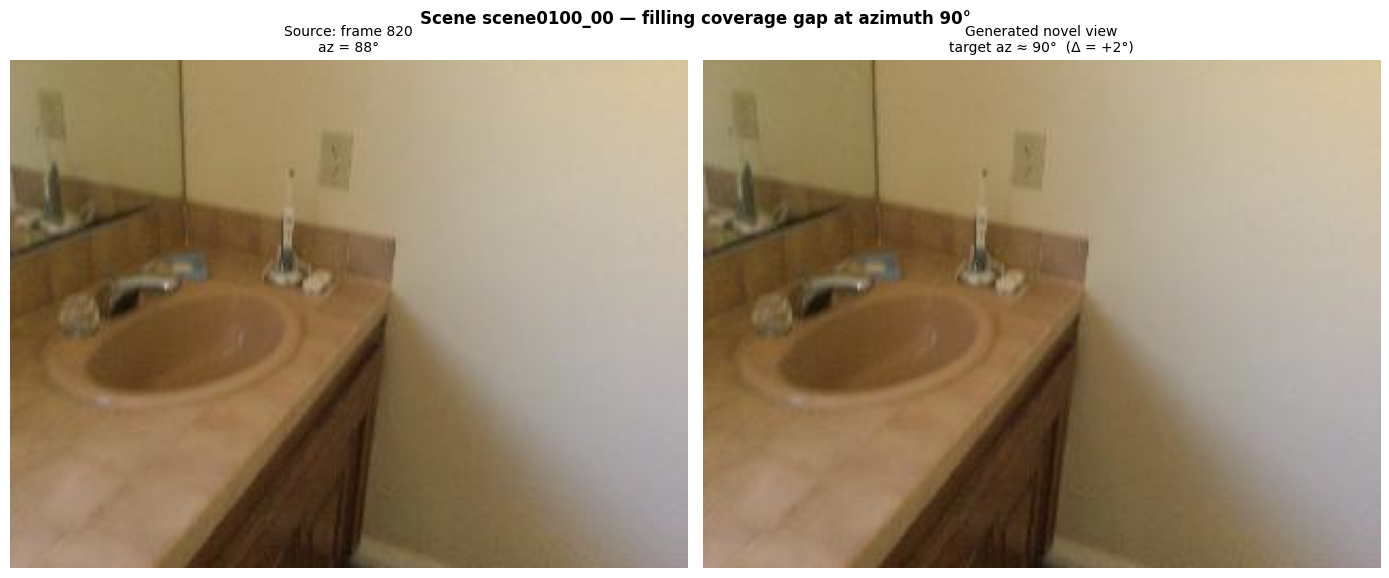

In [37]:
# ── Step 8: Side-by-side comparison ─────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(source_image)
axes[0].set_title(f"Source: frame {source_fid}\naz = {source_az:.0f}°", fontsize=10)
axes[0].axis("off")

axes[1].imshow(novel_view)
axes[1].set_title(f"Generated novel view\ntarget az ≈ {target_az:.0f}°  (Δ = {rotate_deg:+.0f}°)", fontsize=10)
axes[1].axis("off")

fig.suptitle(f"Scene {SCENE_ID} — filling coverage gap at azimuth {target_az:.0f}°",
             fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

In [38]:
# ── Step 9: Save the novel view ─────────────────────────────────────────

out_dir = Path(f"../data/novel_views/{SCENE_ID}")
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / f"novel_az{target_az:.0f}_from{source_fid}.jpg"
novel_view.save(out_path, quality=95)
print(f"Saved to {out_path}")

Saved to ../data/novel_views/scene0100_00/novel_az90_from820.jpg


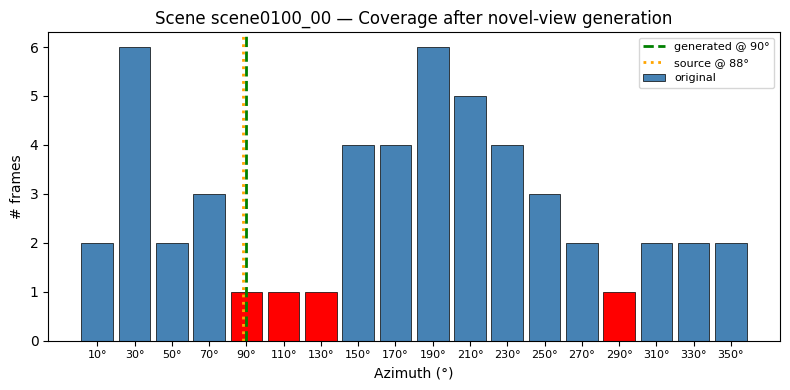


Done!


In [39]:
# ── Step 10: Updated coverage visualisation ─────────────────────────────
#
# Show the original histogram with the newly "filled" gap marked.

fig, ax = plt.subplots(figsize=(8, 4))

colours = []
for i, c in enumerate(counts):
    if gap_mask[i]:
        colours.append("red")
    else:
        colours.append("steelblue")

ax.bar(bin_centres, counts, width=BIN_DEG * 0.85,
       color=colours, edgecolor="k", linewidth=0.5, label="original")

# Mark where we generated a view
ax.axvline(target_az, color="green", linewidth=2, linestyle="--", label=f"generated @ {target_az:.0f}°")
ax.axvline(source_az, color="orange", linewidth=2, linestyle=":", label=f"source @ {source_az:.0f}°")

ax.set_xlabel("Azimuth (°)")
ax.set_ylabel("# frames")
ax.set_title(f"Scene {SCENE_ID} — Coverage after novel-view generation")
ax.set_xticks(bin_centres)
ax.set_xticklabels([f"{int(b)}°" for b in bin_centres], fontsize=8)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

print("\nDone!")